# Customizing the queries

As some of the examples in the basic **Pyrosm** tutorial shows, it is possible to customize the parsing calls using a specific `custom_filter` parameter. This parameter is currently available for all methods except `get_network()`. 
The `custom_filter` can be highly useful if you want to parse only certain type of OpenStreetMap elements from the PBF, such as "residential" buildings or specific shops such as "book" -shops. 

In addition, Pyrosm allows the user to customize which attributes are parsed from the OSM elements into GeoDataFrame columns when parsing the data using the `extra_tags` -parameter. There is a specific set of default attributes that are always parsed from the OSM elements, but as OpenStreetMap is highly flexible in terms of what information can be associated with the data, this parameter makes it easy to parse some of the more "exotic" tags from the OSM. 

**Contents:**

 - [How to modify the parsing process with customized filters?](#Constructing-a-custom-filter)
 - [Advanced filtering](#Advanced-filtering)


## Constructing a custom filter

Before diving into documentation about how to construct a custom filter, it is good to understand a bit how OpenStreetMap data is constructed. OpenStreetMap represents: 

>_"physical features on the ground (e.g., roads or buildings) using tags attached to its basic data structures (its nodes, ways, and relations). Each tag describes a geographic attribute of the feature being shown by that specific node, way or relation"_ ([OSM Wiki, 2020](https://wiki.openstreetmap.org/wiki/Map_Features)). 

Pyrosm is in fact going through these tags behind the scenes and filters OSM data elements according specific predefined criteria that makes it possible to parse e.g. buildings or roads from the data. `custom_filter` can be used to modify this process. 

There are certain rules that comes to constructing the `custom_filter`. The filter should always be a **Python dictionary** where the `key` should be a string and the `value` should be a list of OSM tag-values matching the criteria defined by the user. The `key` should correspond to the key in OpenStreetMap tags (e.g. "building") and the value-list should correspond the OSM values that are associated with the keys. You can see a long list of possible OSM keys and associated values from [OSM Map Features](https://wiki.openstreetmap.org/wiki/Map_Features) wiki page.

As an example, a filter can look something like the one below which would parse all residential and retail buildings from the data:

  - `{"building": ["residential", "retail"]}`
  
This `custom_filter` can be used with `get_buildings()` or `get_osm_by_custom_criteria()` -function. With any other function, this filter does not have any effect on the results, as `"building"` tag is only associated with physical features representing buildings. Hence, if you would use this filter e.g. when parsing roads with `get_network()`, it wouldn't do anything because none of the roads contain information about buildings (*shouldn't at least*).   

Let's test:

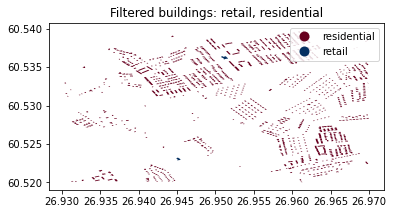

In [1]:
from pyrosm import OSM, get_data
# Get test data 
fp = get_data("test_pbf")

# Initialize the reader
osm = OSM(fp)

# Read buildings with custom filter
my_filter = {"building": ["residential", "retail"]}
buildings = osm.get_buildings(custom_filter=my_filter)

# Plot
title = "Filtered buildings: " + ", ".join(buildings["building"].unique())
ax = buildings.plot(column="building", cmap="RdBu", legend=True)
ax.set_title(title);

As we can see, as a result the data now only includes buildings that have `residential` or `retail` as a value for the key "building". 

### Different kind of filters  

In some cases, such as when parsing Points of Interest (POI) from the PBF, it might be useful to e.g. parse all OSM features that are [shops](https://wiki.openstreetmap.org/wiki/Key:shop). If you do **not** want to specify *what kind* shops to parse from the PBF (i.e. **include all**), it is possible to add `True` as a value in the `custom_filter`, such as in the case `A` below. 

Example filters: 

 - A: `custom_filter={"shop": True}`
 - B: `custom_filter={"shop": True, "tourism": True, "amenity": True, "leisure": True}`
 - C: `custom_filter={"shop": ["alcohol"], "tourism": True, "amenity": ["restaurant", "bar"], "leisure": ["dance"]}`
 
All of the above filters produce slightly different results. The filter `A` would return all shops, `B` would return a broad selection of POIs including all data that relates to shops, tourism, amenities or leisure. 
Filter `C` is very specific filter that might be used by someone in a party mood and being interested in knowing the shops selling alcohol, restaurants and bars, everything related to tourism and leisure activities related to dancing.    

Let's test:

#### Filter A

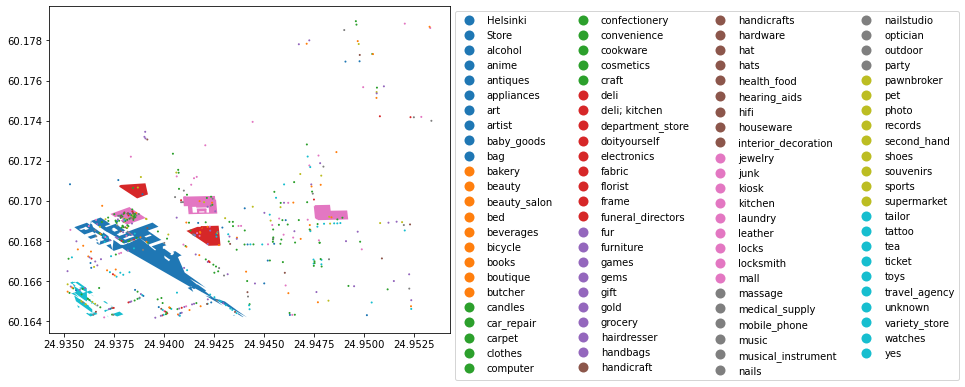

In [2]:
from pyrosm import OSM, get_data
# Get test data 
fp = get_data("helsinki_pbf")

# Initialize the reader
osm = OSM(fp)

# Read POIs with custom filter A
my_filter = {"shop": True}
            
pois = osm.get_pois(custom_filter=my_filter)

# Plot
ax = pois.plot(column="shop", legend=True, markersize=1, figsize=(14,6), legend_kwds=dict(loc='upper left', ncol=4, bbox_to_anchor=(1, 1)))

#### Filter B

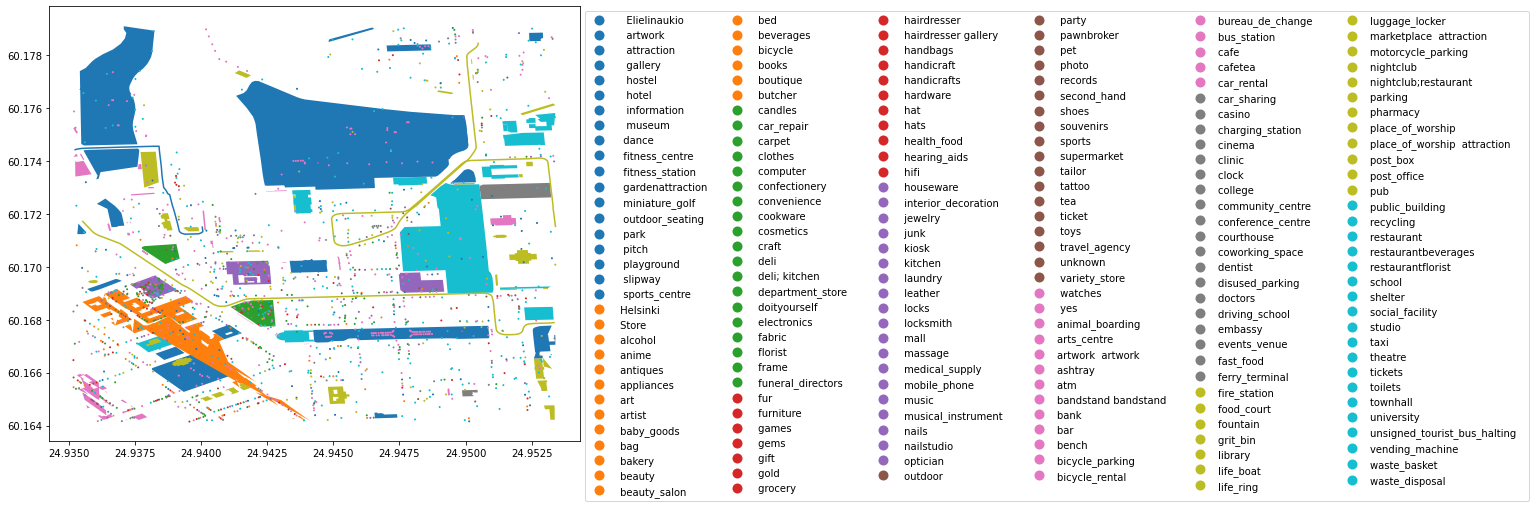

In [3]:
from pyrosm import OSM, get_data
# Get test data 
fp = get_data("helsinki_pbf")

# Initialize the reader
osm = OSM(fp)

# Read POIs with custom filter B
my_filter={"shop": True, "tourism": True, "amenity": True, "leisure": True}
pois = osm.get_pois(custom_filter=my_filter)

# Merge poi type information into a single column
pois["shop"] = pois["shop"].fillna(' ')
pois["amenity"] = pois["amenity"].fillna(' ')
pois["leisure"] = pois["leisure"].fillna(' ')
pois["tourism"] = pois["tourism"].fillna(' ')
pois["poi_type"] = pois["amenity"] + pois["shop"] + pois["leisure"] + pois["tourism"] 

# Plot
ax = pois.plot(column="poi_type", legend=True, markersize=1, figsize=(14,8), legend_kwds=dict(loc='upper left', ncol=6, bbox_to_anchor=(1, 1)))

#### Filter C

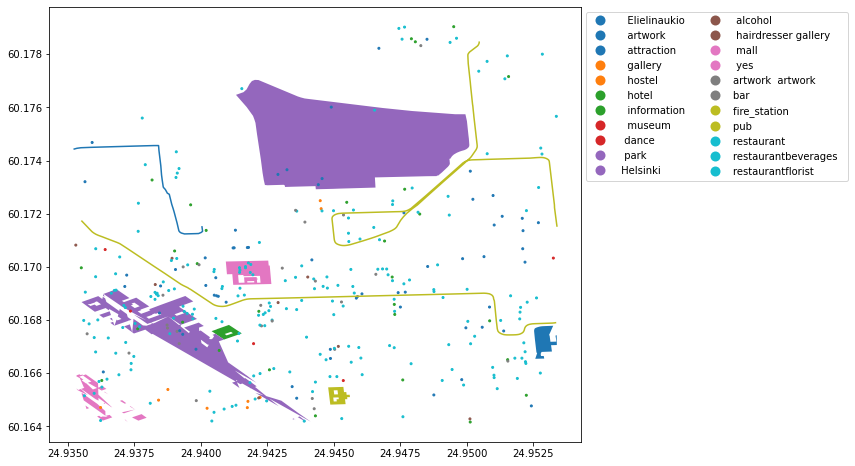

In [4]:
from pyrosm import OSM, get_data
# Get test data 
fp = get_data("helsinki_pbf")

# Initialize the reader
osm = OSM(fp)

# Read POIs with custom filter C
my_filter={"shop": ["alcohol"], "tourism": True, "amenity": ["restaurant", "bar"], "leisure": ["dance"]}
pois = osm.get_pois(custom_filter=my_filter)

# Merge poi type information into a single column
pois["shop"] = pois["shop"].fillna(' ')
pois["amenity"] = pois["amenity"].fillna(' ')
pois["leisure"] = pois["leisure"].fillna(' ')
pois["tourism"] = pois["tourism"].fillna(' ')
pois["poi_type"] = pois["amenity"] + pois["shop"] + pois["leisure"] + pois["tourism"] 

# Plot
ax = pois.plot(column="poi_type", legend=True, markersize=4, figsize=(14,8), legend_kwds=dict(loc='upper left', ncol=2, bbox_to_anchor=(1, 1)))

As we can see from these examples. Using the `custom_filter` is an efficient way to customize what data is extracted from the OpenStreetMap data.

## Advanced filtering

If the above methods do not meet your needs pyrosm provides a method `get_data_by_custom_criteria()` to fully customize what kind of data will be parsed from the OSM PBF, and how the filtering is conducted. The method provides possibility to specify what kind of OSM elements are parsed (nodes, ways, relations, or any combination of these) and it also provides possibility to determine whether the specified filter should be used to `"keep`" the data or `"exclude"` the data from OSM.

Let's start by looking at the help:

In [5]:
from pyrosm import OSM, get_data
fp = get_data("helsinki_pbf")

# Initialize the reader
osm = OSM(fp)
help(osm.get_data_by_custom_criteria)

Help on method get_data_by_custom_criteria in module pyrosm.pyrosm:

get_data_by_custom_criteria(custom_filter, osm_keys_to_keep=None, filter_type='keep', tags_as_columns=None, keep_nodes=True, keep_ways=True, keep_relations=True, extra_attributes=None) method of pyrosm.pyrosm.OSM instance
    Parse OSM data based on custom criteria.
    
    Parameters
    ----------
    
    custom_filter : dict (required)
        A custom filter to filter only specific POIs from OpenStreetMap.
    
    osm_keys_to_keep : str | list
        A filter to specify which OSM keys should be kept.
    
    filter_type : str
        "keep" | "exclude"
        Whether the filters should be used to keep or exclude the data from OSM.
    
        Note: "exclude" works only with ways and relations. With nodes, only "keep" is supported,
        because with "exclude" almost all nodes would always be part of the end result as
        most nodes do not have tag information.
    
    tags_as_columns : list
        W

As we can see, the function contains more parameters than any of the other functions. 

The first two parameters `custom_filter` and `osm_keys_to_keep` can be used to filter the data on a OSM tag level. 
Pyrosm implements a data filtering system that works on **two levels**. 

1. `osm_keys_to_keep` -parameter can be used to specify which kind of OSM elements should be considered as "valid" records for further filtering (i.e. a first level of filtering). For instance, by specifying `osm_keys_to_keep="highway"` tells the filtering algorithm to only consider OSM elements representing roads for further filtering. You can also pass multiple keys to this parameter inside a list, such as `osm_keys_to_keep=["amenity", "shop"]`, which would pass all OSM elements containing "amenity" and "shop" tag-keys for further consideration in the second level of filtering.  
2. `custom_filter` -parameter specifies the second level of filtering that can be used to specify more specifically what kind of OSM elements are accepted for the final GeoDataFrame, such as `{"amenity": ["restaurant", "bar"]}`. See more details [above](#Constructing-a-custom-filter).


**Remarks**

Notice that `osm_keys_to_keep` is an optional parameter, and by default the keys are parsed directly from the `custom_filter` dictionary (the keys of it). However, there are cases when it is useful to specify the `osm_keys_to_keep` yourself. For example, if you are interested to parse schools from the data you could use `custom_filter={"amenity": ["school"]}`. By default, this would parse all amenities that have a tag `"school"`. **However**, if you would be interested to find only **buildings that are tagged as schools** you could use a combination of the two filters:

 - `osm_keys_to_keep="building"`
 - `custom_filter={"amenity": ["school"]}`
 
The `osm_keys_to_keep` -parameter takes care that only such OSM elements that have a tag `"building"` are considered for further filtering, and then the `custom_filter` takes care that from buildings only such rows that have been tagged as `"school"` will be accepted to the final result.

- Let's try this out:

In [6]:
from pyrosm import OSM, get_data
osm = OSM(get_data("helsinki_region_pbf"))

# Create a custom filter that finds all schools from the data
custom_filter = {"amenity": ["school"]}

# Specify that you are only interested in such 
# elements that have been tagged as buildings
osm_keys_to_keep = ["building"]

# Parse the data
schools_that_are_buildings = osm.get_data_by_custom_criteria(osm_keys_to_keep=osm_keys_to_keep,
                                                            custom_filter=custom_filter)

print("Number of schools that have been tagged as buildings:", len(schools_that_are_buildings))

# ============
# Comparison
# ============

# For comparison, let's parse all schools without the requirement of being a building
# i.e. we do not use the 'osm_keys_to_keep' parameter at all
all_schools = osm.get_data_by_custom_criteria(custom_filter=custom_filter)
print("Number of schools altogether:", len(all_schools))

Number of schools that have been tagged as buildings: 1171
Number of schools altogether: 512


Okay, as we can see there are 72 buildings that have been tagged as schools in the data. This is quite much fewer than the number of all schools existing in the data. Following this principle, it is possible to make highly customized queries.


### Controlling which OSM element types are returned

It is also possible to determine what kind of OSM elements are returned to the final GeoDataFrame. By default the `get_data_by_custom_criteria()` returns all elements, i.e. **nodes**, **ways** and **relations**. 
Let's continue from the previous example and assume that you would be interested to find out all schools that are Polygons. There are different ways to filter such data (e.g. utilizing the `geom_type` attribute of a GeoDataFrame), however, one way that his can be accomplished is to **filter out** such OSM elements that are **nodes** (i.e. points). 

You can easily control the type OSM elements that will be returned by using parameters:
 
 - `keep_nodes`
 - `keep_ways`
 - `keep_relations`
 
By default all of these parameters are specified as `True`. However, if for example specify `nodes=False`, pyrosm will return only ways and relations but skip nodes. 

Let's test this by filtering the schools that are nodes:

In [7]:
# Continuing from the previous example ..

# Parse all schools that are not nodes
custom_filter = {"amenity": ["school"]}

# Pass keep_nodes=False to filter out nodes
schools_that_are_not_nodes = osm.get_data_by_custom_criteria(custom_filter=custom_filter,
                                                             keep_nodes=False)


print("Number of schools that are not nodes:", len(schools_that_are_not_nodes))

Number of schools that are not nodes: 421


Okay, now we have only 421 schools left (from 512). 

Let's take a look of the geometry types: 

In [8]:
# Add information about the geometry type
schools_that_are_not_nodes["geom_type"] = schools_that_are_not_nodes.geometry.geom_type

# Print the geom types
schools_that_are_not_nodes["geom_type"].unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

Great! Now we only have Polygons and MultiPolygons in the data. 

<div class="alert alert-info">
    
Note: The `way` OSM element does not necessary mean that the geometries will be Polygons. They can be also LineStrings (depends on what kind of OSM data is parsed). Hence, if you need to parse OSM data based on geometry type, it is safer to use the `GeoDataFrame.geometry.geom_type` function (as above) and select the rows using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html). 
    
</div>

### `keep` vs `exclude` data with custom filters 

Pyrosm `get_data_by_custom_criteria()` makes it possible to also **filter out** records based on certain criteria. With parameter `filter_type` you specify whether the filters should be used as a criteria for keeping the records or excluding them.

One example of when using `filter_type="exclude"` can be useful, is for example when filtering specific roads from the OSM data. In fact, the `get_network()` function works exactly in such a way.

As an example of the excluding filter, let's create a custom filter that parses all the cycling roads from OSM in a similar manner as is done by get_network("cycling"):

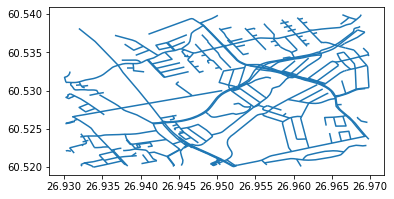

In [9]:
from pyrosm import OSM, get_data

# When we want to keep only roads we want to only include data having "highway" tag (i.e. a road)
# we can pass osm_keys_to_keep: This is a "first level" of filtering
osm_keys_to_keep = "highway"

# Second level of filtering is done by passing our custom filter:
custom_filter = dict(
        # Areas are not parsed for networks by default
        area=['yes'],
        # OSM "highway" elements that have these tags, cannot be cycled
        highway=['footway', 'steps', 'corridor', 'elevator', 'escalator', 'motor', 'proposed',
                 'construction', 'abandoned', 'platform', 'raceway', 'motorway', 'motorway_link'],
        # If specifically said that cycling is not allowed, exclude such
        bicycle=['no'],
        # Do not include private roads
        service=['private']
    )

# In this case we want to EXCLUDE all the rows that have tags matching the criteria above
filter_type = "exclude"

# Run and get all cycling roads
osm = OSM(get_data("test_pbf"))
cycling = osm.get_data_by_custom_criteria(custom_filter=custom_filter, 
                                          osm_keys_to_keep=osm_keys_to_keep,
                                          filter_type=filter_type)
cycling.plot()

Now we have filtered all the roads that can be cycled. This corresponds to the one procuded by default with `get_network("cycling")`:

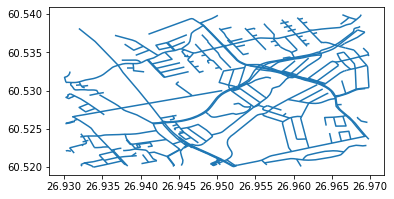

In [10]:
cycling2 = osm.get_network("cycling")
cycling2.plot()